### Part 1: Compute Best-Level OFI

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
# Load and preprocess
df = pd.read_csv('first_25000_rows.csv')
df['ts_event_dt'] = pd.to_datetime(df['ts_event'])
df.sort_values(['symbol','ts_event_dt'], inplace=True)

# Compute event-level best-level OFI
prev = df[['bid_px_00','bid_sz_00','ask_px_00','ask_sz_00']].shift(1)
curr = df[['bid_px_00','bid_sz_00','ask_px_00','ask_sz_00']]
bid_ofi = np.where(curr['bid_px_00'] > prev['bid_px_00'], 
                    curr['bid_sz_00'],
                    np.where(curr['bid_px_00'] == prev['bid_px_00'],
                             curr['bid_sz_00'] - prev['bid_sz_00'],
                             -curr['bid_sz_00']))
ask_ofi = np.where(curr['ask_px_00'] < prev['ask_px_00'], 
                    -curr['ask_sz_00'],
                    np.where(curr['ask_px_00'] == prev['ask_px_00'],
                             -(curr['ask_sz_00'] - prev['ask_sz_00']),
                             curr['ask_sz_00']))
df['ofi_best_event'] = bid_ofi + ask_ofi

# Filter first 5000 for clarity
events = df[['ts_event_dt','ofi_best_event']].head(5000)
events

,ts_event_dt,ofi_best_event
0,2024-10-21 11:54:29.221064336+00:00,61.0
1,2024-10-21 11:54:29.223769812+00:00,2.0
2,2024-10-21 11:54:29.225030400+00:00,3.0
3,2024-10-21 11:54:29.712434212+00:00,0.0
4,2024-10-21 11:54:29.764673165+00:00,0.0
...,...,...
4995,2024-10-21 13:04:16.583527688+00:00,0.0
4996,2024-10-21 13:04:17.976461017+00:00,0.0
4997,2024-10-21 13:04:20.085638629+00:00,0.0
4998,2024-10-21 13:04:20.085651109+00:00,0.0


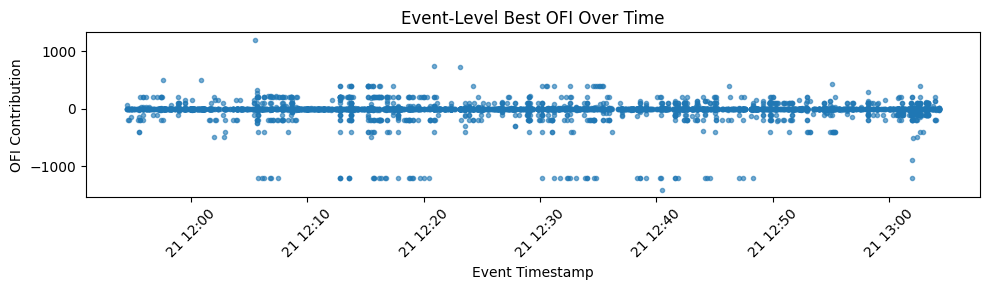

In [3]:
# 1) Event-level OFI time-series
fig1, ax1 = plt.subplots(figsize=(10, 3))
ax1.plot(events['ts_event_dt'], events['ofi_best_event'], '.', alpha=0.6)
ax1.set_title('Event-Level Best OFI Over Time')
ax1.set_xlabel('Event Timestamp')
ax1.set_ylabel('OFI Contribution')
plt.xticks(rotation=45)
plt.tight_layout()

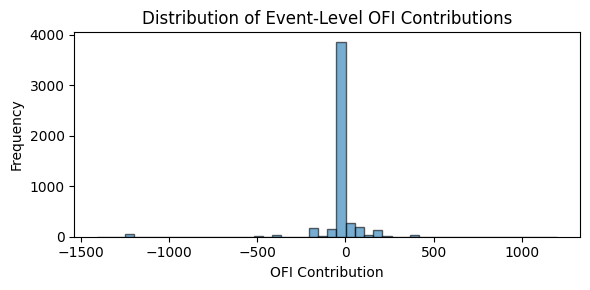

In [4]:
# 2) Histogram of event-level OFI
fig2, ax2 = plt.subplots(figsize=(6, 3))
ax2.hist(events['ofi_best_event'], bins=50, edgecolor='k', alpha=0.6)
ax2.set_title('Distribution of Event-Level OFI Contributions')
ax2.set_xlabel('OFI Contribution')
ax2.set_ylabel('Frequency')
plt.tight_layout()

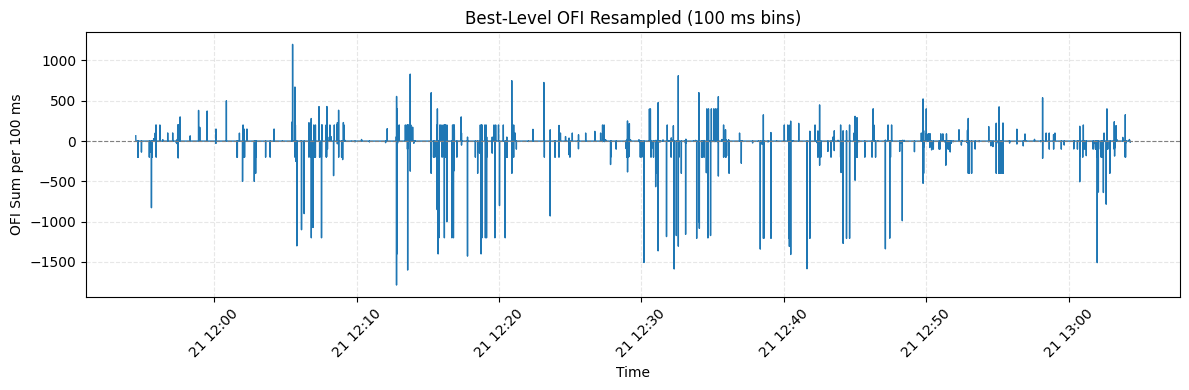

In [5]:
# Set timestamp index
df.set_index('ts_event_dt', inplace=True)

# Resample to 100 ms bins, summing OFI contributions
ofi_100ms = df['ofi_best_event'].resample('100ms').sum().fillna(0)

# Plot 100 ms resampled OFI
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ofi_100ms.index, ofi_100ms.values, linewidth=1)
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_title('Best-Level OFI Resampled (100 ms bins)')
ax.set_xlabel('Time')
ax.set_ylabel('OFI Sum per 100 ms')
ax.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Part 2: Multi-Level OFI

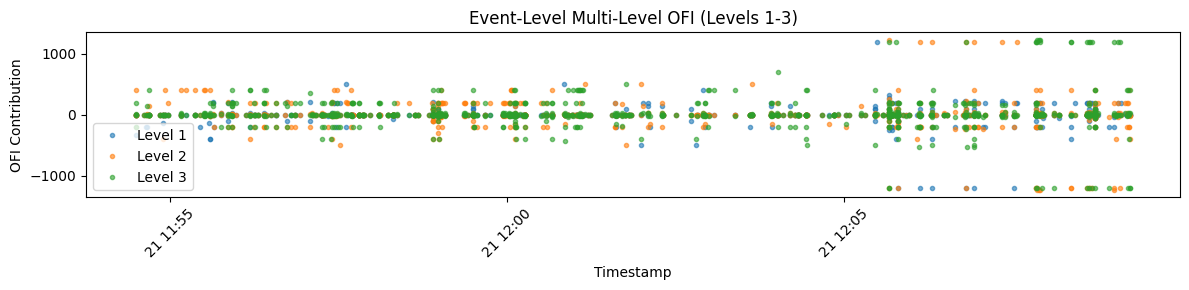

In [8]:
df = pd.read_csv('first_25000_rows.csv')
df['ts_event_dt'] = pd.to_datetime(df['ts_event'])
df.sort_values(['symbol','ts_event_dt'], inplace=True)

# Compute event-level multi-level OFI (levels 1–10)
for m in range(10):
    # Previous snapshot for level m
    prev_bid_px = df[f'bid_px_{m:02d}'].shift(1)
    prev_bid_sz = df[f'bid_sz_{m:02d}'].shift(1)
    prev_ask_px = df[f'ask_px_{m:02d}'].shift(1)
    prev_ask_sz = df[f'ask_sz_{m:02d}'].shift(1)
    # Current snapshot
    curr_bid_px = df[f'bid_px_{m:02d}']
    curr_bid_sz = df[f'bid_sz_{m:02d}']
    curr_ask_px = df[f'ask_px_{m:02d}']
    curr_ask_sz = df[f'ask_sz_{m:02d}']
    
    # Bid-side contribution
    of_b = np.where(curr_bid_px > prev_bid_px,
                    curr_bid_sz,
                    np.where(curr_bid_px == prev_bid_px,
                             curr_bid_sz - prev_bid_sz,
                             -curr_bid_sz))
    # Ask-side contribution
    of_a = np.where(curr_ask_px > prev_ask_px,
                    -curr_ask_sz,
                    np.where(curr_ask_px == prev_ask_px,
                             prev_ask_sz - curr_ask_sz,
                             curr_ask_sz))
    # Net OFI for level m+1
    df[f'ofi_level{m+1}_event'] = of_b - of_a

# Select first 1000 events for visualization
events_ml = df[['ts_event_dt'] + [f'ofi_level{i}_event' for i in range(1,11)]].head(1000)

# 1) Line plot: event-level OFI for levels 1, 2, and 3
fig1, ax1 = plt.subplots(figsize=(12, 3))
for i in [1,2,3]:
    ax1.plot(events_ml['ts_event_dt'], events_ml[f'ofi_level{i}_event'],
             marker='.', linestyle='None', label=f'Level {i}', alpha=0.6)
ax1.set_title('Event-Level Multi-Level OFI (Levels 1-3)')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('OFI Contribution')
ax1.legend()
plt.xticks(rotation=45)
plt.tight_layout()

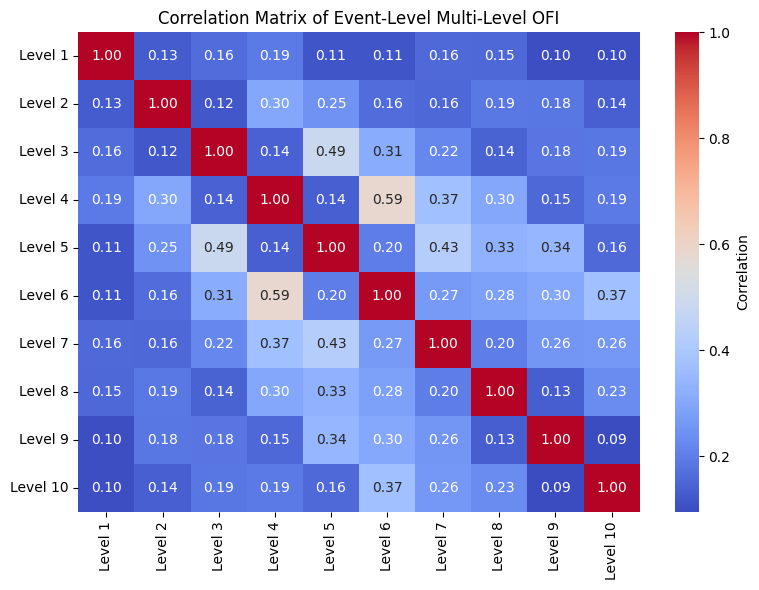

In [9]:
import seaborn as sns

# Compute correlation matrix of event-level multi-level OFI
levels_event = [f'ofi_level{i}_event' for i in range(1, 11)]
corr_event = df[levels_event].corr()

# Plot heatmap
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_event, annot=True, fmt=".2f", cmap='coolwarm', 
            xticklabels=[f'Level {i}' for i in range(1,11)],
            yticklabels=[f'Level {i}' for i in range(1,11)],
            cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Matrix of Event-Level Multi-Level OFI')
plt.tight_layout()
plt.show()

### Part 3: Integrated OFI

In [11]:
from sklearn.decomposition import PCA

# Load & preprocess as before
df = pd.read_csv('first_25000_rows.csv')
df['ts_event_dt'] = pd.to_datetime(df['ts_event'])
df.sort_values(['symbol','ts_event_dt'], inplace=True)

# Compute event-level multi-level OFI (levels 1–10) if not already present
levels_event = []
for m in range(10):
    col = f'ofi_level{m+1}_event'
    levels_event.append(col)
    if col not in df:
        prev_bid_px = df[f'bid_px_{m:02d}'].shift(1)
        prev_bid_sz = df[f'bid_sz_{m:02d}'].shift(1)
        prev_ask_px = df[f'ask_px_{m:02d}'].shift(1)
        prev_ask_sz = df[f'ask_sz_{m:02d}'].shift(1)
        curr_bid_px = df[f'bid_px_{m:02d}']
        curr_bid_sz = df[f'bid_sz_{m:02d}']
        curr_ask_px = df[f'ask_px_{m:02d}']
        curr_ask_sz = df[f'ask_sz_{m:02d}']
        of_b = np.where(curr_bid_px > prev_bid_px,
                        curr_bid_sz,
                        np.where(curr_bid_px == prev_bid_px,
                                 curr_bid_sz - prev_bid_sz,
                                 -curr_bid_sz))
        of_a = np.where(curr_ask_px > prev_ask_px,
                        -curr_ask_sz,
                        np.where(curr_ask_px == prev_ask_px,
                                 -(curr_ask_sz - prev_ask_sz),
                                 curr_ask_sz))
        df[col] = of_b - of_a

# Prepare data matrix X for PCA
X = df[levels_event].fillna(0).values

# Fit PCA for 1st component
pca = PCA(n_components=1)
df['ofi_integrated_event'] = pca.fit_transform(X).flatten()

# Retrieve and normalize PCA weights
weights = pca.components_[0]
weights_norm = weights / np.sum(np.abs(weights))
print("ℓ1-normalized PCA weights for levels 1–10:")
for i, w in enumerate(weights_norm, 1):
    print(f"Level {i}: {w:.3f}")

# Show head of integrated event-level OFI
df[['ts_event_dt','ofi_integrated_event']].head()


ℓ1-normalized PCA weights for levels 1–10:
Level 1: -0.030
Level 2: -0.079
Level 3: -0.141
Level 4: -0.164
Level 5: -0.137
Level 6: -0.117
Level 7: -0.088
Level 8: -0.090
Level 9: -0.081
Level 10: -0.072


,ts_event_dt,ofi_integrated_event
0,2024-10-21 11:54:29.221064336+00:00,539.390405
1,2024-10-21 11:54:29.223769812+00:00,14.141464
2,2024-10-21 11:54:29.225030400+00:00,14.052305
3,2024-10-21 11:54:29.712434212+00:00,-69.318105
4,2024-10-21 11:54:29.764673165+00:00,97.957666


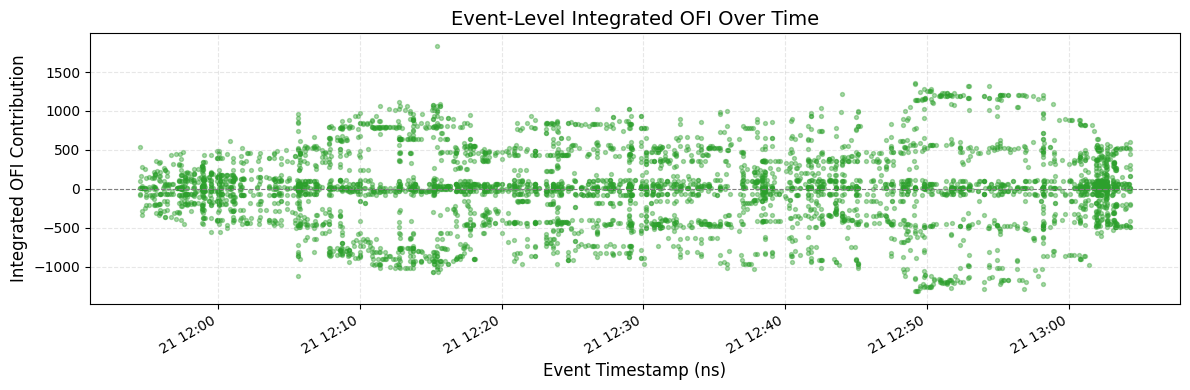

In [12]:
events_int = df[['ts_event_dt','ofi_integrated_event']].head(5000)

fig1, ax1 = plt.subplots(figsize=(12, 4))
ax1.scatter(events_int['ts_event_dt'], events_int['ofi_integrated_event'],
            s=8, alpha=0.4, color='tab:green')
ax1.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax1.grid(True, linestyle='--', alpha=0.3)
ax1.set_title('Event-Level Integrated OFI Over Time', fontsize=14)
ax1.set_xlabel('Event Timestamp (ns)', fontsize=12)
ax1.set_ylabel('Integrated OFI Contribution', fontsize=12)
fig1.autofmt_xdate()
plt.tight_layout()
plt.show()

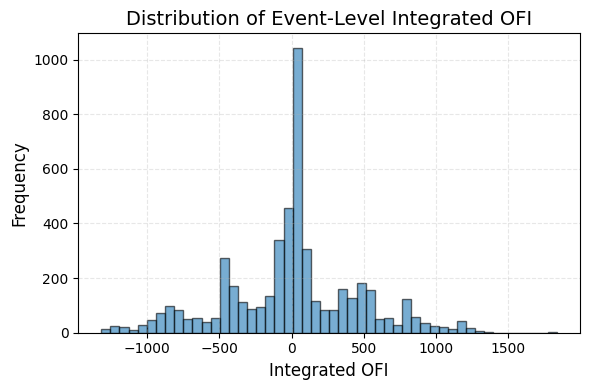

In [13]:
fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.hist(events_int['ofi_integrated_event'], bins=50, edgecolor='k', alpha=0.6)
ax2.set_title('Distribution of Event-Level Integrated OFI', fontsize=14)
ax2.set_xlabel('Integrated OFI', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

### Part 5: Cross-Asset Event-Level Integrated OFI

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Load and preprocess
df = pd.read_csv('first_25000_rows.csv')
df['ts_event_dt'] = pd.to_datetime(df['ts_event'])
df.sort_values(['symbol','ts_event_dt'], inplace=True)

# Compute event-level multi-level OFI (levels 1–10)
for m in range(10):
    prev_bid_px = df[f'bid_px_{m:02d}'].shift(1)
    prev_bid_sz = df[f'bid_sz_{m:02d}'].shift(1)
    prev_ask_px = df[f'ask_px_{m:02d}'].shift(1)
    prev_ask_sz = df[f'ask_sz_{m:02d}'].shift(1)
    curr_bid_px = df[f'bid_px_{m:02d}']
    curr_bid_sz = df[f'bid_sz_{m:02d}']
    curr_ask_px = df[f'ask_px_{m:02d}']
    curr_ask_sz = df[f'ask_sz_{m:02d}']
    
    of_b = np.where(curr_bid_px > prev_bid_px,
                    curr_bid_sz,
                    np.where(curr_bid_px == prev_bid_px,
                             curr_bid_sz - prev_bid_sz,
                             -curr_bid_sz))
    of_a = np.where(curr_ask_px < prev_ask_px,
                    -curr_ask_sz,
                    np.where(curr_ask_px == prev_ask_px,
                             curr_ask_sz - prev_ask_sz,
                             curr_ask_sz))
    df[f'ofi_level{m+1}_event'] = of_b - of_a

# PCA for integrated event-level OFI
levels_event = [f'ofi_level{i}_event' for i in range(1, 11)]
X = df[levels_event].fillna(0).values
pca = PCA(n_components=1)
df['ofi_integrated_event'] = pca.fit_transform(X).flatten()

# Pivot to cross-asset matrix using pivot_table
df_event_int = df[['symbol','ts_event_dt','ofi_integrated_event']]
cross_event = df_event_int.pivot_table(
    index='ts_event_dt',
    columns='symbol',
    values='ofi_integrated_event',
    aggfunc='first'
).fillna(0)

# Display the cross-asset integrated OFI matrix
display(cross_event.head())


symbol,AAPL
ts_event_dt,
2024-10-21 11:54:29.221064336+00:00,540.119778
2024-10-21 11:54:29.223769812+00:00,14.584987
2024-10-21 11:54:29.225030400+00:00,14.497075
2024-10-21 11:54:29.712434212+00:00,-68.243140
2024-10-21 11:54:29.764673165+00:00,97.764761


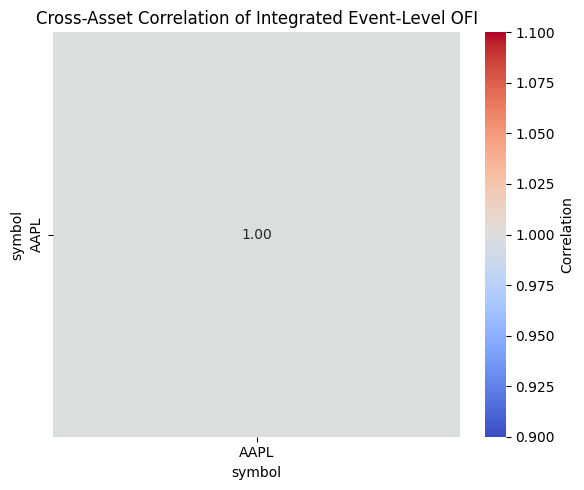

In [27]:
corr = cross_event.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', cbar_kws={'label':'Correlation'})
plt.title('Cross-Asset Correlation of Integrated Event-Level OFI')
plt.tight_layout()
plt.show()

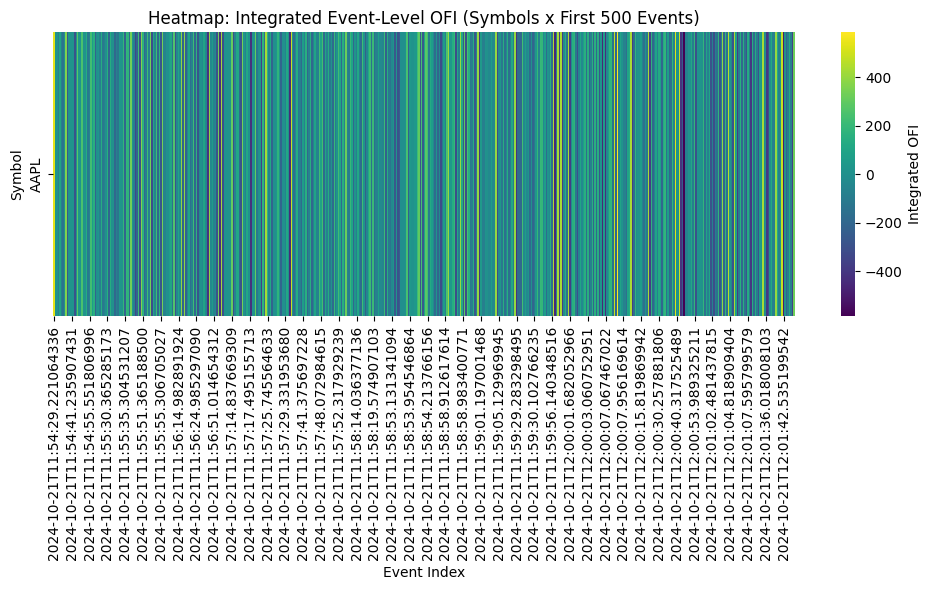

In [28]:
plt.figure(figsize=(10,6))
sns.heatmap(
    cross_event.iloc[:500].T,
    cmap='viridis',
    cbar_kws={'label':'Integrated OFI'}
)
plt.title('Heatmap: Integrated Event-Level OFI (Symbols x First 500 Events)')
plt.xlabel('Event Index')
plt.ylabel('Symbol')
plt.tight_layout()
plt.show()

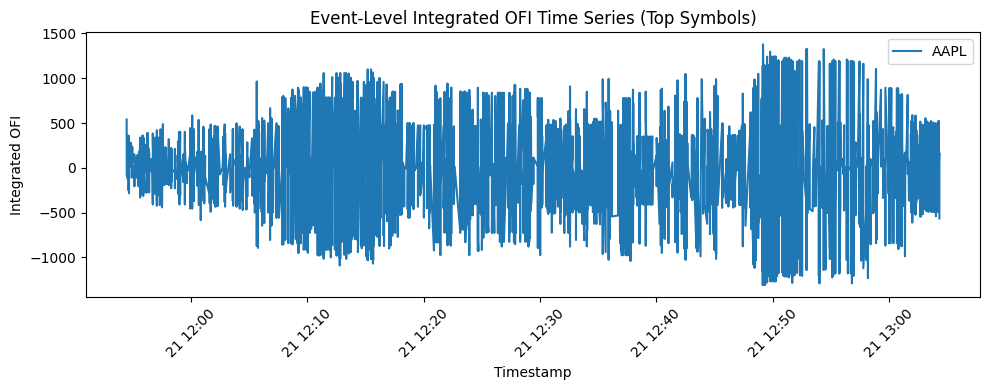

In [29]:
symbols = cross_event.columns.tolist()
if len(symbols) >= 1:
    plt.figure(figsize=(10,4))
    for sym in symbols[:3]:
        plt.plot(cross_event.index, cross_event[sym], label=sym)
    plt.title('Event-Level Integrated OFI Time Series (Top Symbols)')
    plt.xlabel('Timestamp')
    plt.ylabel('Integrated OFI')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()